In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

import pandas as pd
from keras import initializers


from keras.layers import Activation

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import math

from scipy.stats import linregress

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib



In [2]:
def custom_activation(x):
    
    return tf.math.erf(x/(tf.sqrt(2.*N)))

def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return 1/2*tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [3]:
def teacher_SCM(N,M,seed_M):
    tf.random.set_seed(seed_M)
    teacher=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),

    tf.keras.layers.Dense(M,activation=custom_activation,name="layer1",use_bias=False,kernel_initializer=initializers.orthogonal(gain=np.sqrt(N)))])

    #tf.keras.layers.Dense(M,activation=custom_activation,name="layer1",use_bias=False,kernel_initializer=initializers.RandomNormal(mean=0,stddev=1.,seed=seed_M))])

    out=tf.keras.layers.Dense(1, activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=0,mean=1/np.sqrt(M)))
    out.trainable=False
    teacher.add(out)
    teacher.compile(
        optimizer=tf.keras.optimizers.SGD(1),
        loss=my_loss_fn,
        metrics=None,
   
    )
        
    new_weights=np.zeros((N,M))
    
    for i in range(0,M):
        
        new_weights[:,i]=teacher.weights[0].numpy()[:,i]/np.linalg.norm(teacher.weights[0].numpy()[:,i])*np.sqrt(N)


    b=[]
    
    b.append(new_weights)
    b.append(teacher.weights[1].numpy())

    
    teacher.set_weights(b)
    
    return teacher



def student_SCM(N,K,M,eta,seed_K):
    tf.random.set_seed(seed_K)
    np.random.seed(seed_K)
    student=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),
    tf.keras.layers.Dense(K,activation=custom_activation,name="layer1",use_bias=False,
    bias_initializer=initializers.Zeros(),
    kernel_initializer=initializers.random_normal(stddev=1.,mean=0,seed=seed_K))])

    out=tf.keras.layers.Dense(1, 
    activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=1/np.sqrt(K),mean=0.))
    out.trainable=True
    student.add(out)
    student.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=eta),
        loss=my_loss_fn,
        metrics=None,
   
    )
    

    return student

In [4]:
def batch3(student,teacher,N,K,M,p,var,epo,eta,seeds):
 
    
    risk=[]
    error_test=[]
    np.random.seed(seeds)
    tf.random.set_seed(seeds)

    x_test=np.random.default_rng().standard_normal(size=(50000,N), dtype='float32')
 
    x_train=np.random.default_rng().standard_normal(size=(p,N), dtype='float32')
  
    

   
    
    lr=eta
 
    student_=student(N,K,M,lr,90)
   
    teacher_=teacher(N,M,7)
    labels=teacher_(x_train)
    labels_test=teacher_(x_test)
    train=[]
    weights=[]
    c=[]
    for ep in range(epo):
        weights.append(student_.weights[0].numpy()[:])
        c.append(student_.weights[1].numpy()[:])
        
        
        history =student_.fit(
           x=x_train,
            y=labels,
            epochs = 1,
            batch_size=p,
            verbose = 0,
            use_multiprocessing=True,shuffle=True)

        error_test.append(np.mean(teacher_.loss(labels_test,student_(x_test))))
        train.append(history.history["loss"])
   
        if not ep%100:
            print(ep)
            print(error_test[ep])
            
            
        
    return np.array(error_test),np.array(train),np.array(weights),np.array(c),teacher_

In [ ]:
L=[16]
for N in L:
    print(N)
    for j in range(0,1):
        K=10
        p=160
        eta=0.03
        end=10000
        M=1   
            
        eg10,train10,w10,c10,teacher10=batch3(student_SCM,teacher_SCM,N,K,M,p,0.0,end,eta,seeds=5)
            
            

In [146]:
t=np.linspace(1,end,end)

In [305]:
#df10=pd.DataFrame(c10.reshape(10000,10))
#df100=pd.DataFrame(c100.reshape(10000,100))
#df1000=pd.DataFrame(c1000.reshape(10000,1000))

In [306]:
#df10.to_csv("lazy_K10_c_weights.csv",sep=";")
#df100.to_csv("lazy_K100_c_weights.csv",sep=";")
#df1000.to_csv("lazy_K1000_c_weights.csv",sep=";")

In [7]:
R10=[]
Q10=[]
for i in range(end):
    
    R10.append(w10[i].T@teacher10.weights[0].numpy()/N)
R10=np.array(R10)

In [21]:
R50=[]
Q50=[]
for i in range(end):
    
    R50.append(w50[i].T@teacher50.weights[0].numpy()/N)
R50=np.array(R50)

In [175]:
R100=[]
Q100=[]
for i in range(end):
    
    R100.append(w100[i].T@teacher100.weights[0].numpy()/N)
R100=np.array(R100)

In [176]:
R1000=[]
Q1000=[]
for i in range(end):
    
    R1000.append(w1000[i].T@teacher1000.weights[0].numpy()/N)
R1000=np.array(R1000)

In [8]:
def func(R,end):
    a=[]
    for i in range(end):
        a.append(np.linalg.norm(R[i]-R[0])/np.linalg.norm(R[0]))
        
    return np.array(a)

In [22]:
a1=func(R10,end)
a2=func(R100,end)
a3=func(R1000,end)

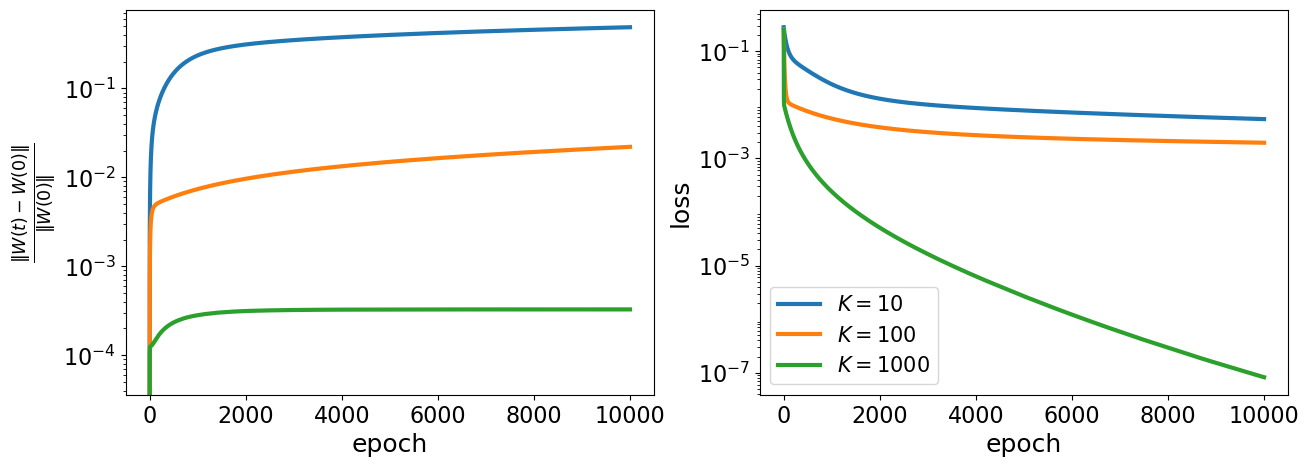

In [281]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].set_yscale("log")
ax[0].plot(a1,lw=3)
ax[0].plot(a2,lw=3)
ax[0].plot(a3,lw=3)
ax[0].set_xlabel("epoch",size=18)
ax[0].set_ylabel(r"$\frac{\Vert W\left(t\right)-W\left(0\right)\Vert}{\Vert W\left(0\right)\Vert}$",size=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=16)
fig.set_figheight(5)
fig.set_figwidth(15)

ax[1].set_yscale("log")
ax[1].plot(t[0:b],train10[:],lw=3,)
ax[1].plot(t[0:b],train100[:],lw=3)
ax[1].plot(t[0:b],train1000[:],lw=3)
ax[1].set_xlabel("epoch",size=18)
ax[1].set_ylabel("loss",size=18)
#ax[1].set_xticks([1000],size=22)
ax[1].set_yticks([0.1,0.001,0.00001,0.0000001],size=22)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=16)
ax[1].legend([r"$K=10$",r"$K=100$",r"$K=1000$"],fontsize=15)
#plt.savefig("lazy_two_layer_nn.pdf",bbox_inches="tight")
plt.show();